algorithme d’ensemble supervisé, fondé sur le principe du **boosting** :
il combine de nombreux **arbres de décision faibles** (peu profonds) pour construire un modèle global puissant.

##  Principe général
- Le modèle est construit **itérativement** : chaque nouvel arbre apprend à **corriger les erreurs** des arbres précédents.
- L’apprentissage est guidé par la **descente de gradient** appliquée à la fonction de perte (souvent la log-loss pour la classification).
- Contrairement au Random Forest (bagging), le boosting est **séquentiel** : chaque arbre dépend des résidus du précédent.


##  Paramètres essentiels à connaître
| Paramètre | Rôle | Recommandation |
|------------|------|----------------|
| **n_estimators** | Nombre d’arbres faibles | 200–500 (plus = mieux, mais plus lent) |
| **learning_rate** | Vitesse d’apprentissage | 0.01–0.1 (plus bas = plus stable) |
| **max_depth** | Profondeur max des arbres | 3–6 (limite la complexité) |
| **subsample** | Fraction d’échantillons utilisés à chaque itération | 0.7–0.9 pour éviter le sur-apprentissage |
| **random_state** | Graine aléatoire | Pour la reproductibilité |

##  Avantages

 Bonne capacité à capturer des interactions non linéaires  
 Interprétable via l’importance des variables (`feature_importances_`)  
 Moins sensible au bruit qu’un seul arbre de décision  

##  Limites
 Entraînement plus lent que le Random Forest  
 Paramétrage plus délicat (learning_rate, nombre d’arbres)  
 Pas naturellement robuste aux données très déséquilibrées (il faut ajuster le **seuil de décision** comme ici à 0.1)


In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))  # permet d’accéder au dossier parent
from src.utils.imports import *
from src.utils.config import CREDITCARD_PATH

c:\Users\kadas\Desktop\Fraude\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Toutes les librairies principales importées avec succès (Data | ML | MLOps | API | Orchestration).


In [2]:
df = pd.read_csv(CREDITCARD_PATH)
print(f" Fichier chargé depuis : {CREDITCARD_PATH}")

 Fichier chargé depuis : C:\Users\kadas\Desktop\Fraude\fraudflow\data\creditcard.csv


In [3]:
df=df[["V14","V18","V7","V4","V11","V12","V10","V16","V3","V17","V9","V2","Class", "Amount","Time"]]

In [4]:
# Features et cible
X = df.drop(columns=["Class", "Amount"])
y = df["Class"]

In [5]:
#  Séparation Train / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=90
)

In [6]:
# 1️. Entraînement
gb = GradientBoostingClassifier(
    n_estimators=400,        # nombre d'arbres (200–500)
    learning_rate=0.05,      # plus bas = plus stable
    max_depth=5,             # profondeur des arbres
    subsample=0.8,           # sous-échantillonnage pour éviter l’overfitting
    random_state=90
)
gb.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.05
,n_estimators,400
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [ ]:
# 2️. Prédictions et probabilités
y_pred_gb = gb.predict(X_test) # Prédictions binaires (0 ou 1) selon le seuil par défaut de 0.5
y_proba_gb = gb.predict_proba(X_test)[:, 1] # Probabilités estimées pour la classe positive (1)

In [8]:
#  Choix du seuil personnalisé 
seuil = 0.1 
y_pred_custom = (y_proba_gb >= 0.1).astype(int)   # seuil = 0.1   

In [9]:
# 3️. Évaluation

auprc_gb = average_precision_score(y_test, y_proba_gb)
print(f"\nAUPRC (Gradient Boosting) : {auprc_gb:.4f}")

#  Rapport avec seuil par défaut (0.5)
print("\n=== Classification Report (seuil par défaut = 0.5) ===")
print(classification_report(y_test, y_pred_gb, digits=4))

#  Rapport avec ton seuil personnalisé (0.1)
print(f"\n=== Classification Report (seuil personnalisé = {seuil}) ===")
print(classification_report(y_test, y_pred_custom, digits=4))


AUPRC (Gradient Boosting) : 0.6319

=== Classification Report (seuil par défaut = 0.5) ===
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     56864
           1     0.9412    0.6531    0.7711        98

    accuracy                         0.9993     56962
   macro avg     0.9703    0.8265    0.8854     56962
weighted avg     0.9993    0.9993    0.9993     56962


=== Classification Report (seuil personnalisé = 0.1) ===
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9996     56864
           1     0.9143    0.6531    0.7619        98

    accuracy                         0.9993     56962
   macro avg     0.9568    0.8265    0.8808     56962
weighted avg     0.9993    0.9993    0.9992     56962



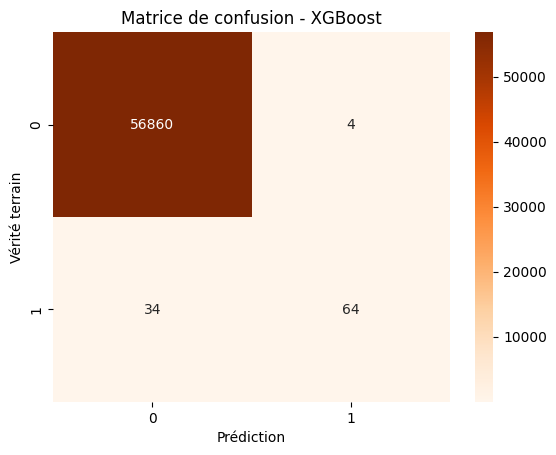

In [10]:
# 4. Matrice de confusion

# Génère la matrice
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Oranges')
plt.title("Matrice de confusion - XGBoost")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

In [11]:
# Extraction des éléments
VN = cm_gb[0, 0]  # Vrais négatifs
FP = cm_gb[0, 1]  # Faux positifs
FN = cm_gb[1, 0]  # Faux négatifs
VP = cm_gb[1, 1]  # Vrais positifs

# Calcul des métriques de base
specificite = VN / (VN + FP)             # TNR
sensibilite = VP / (VP + FN)             # Recall
precision = VP / (VP + FP)               # Precision

print(f"Spécificité (TNR) : {specificite:.4f}")
print(f"Sensibilité (Recall) : {sensibilite:.4f}")
print(f"Précision (PPV) : {precision:.4f}")

Spécificité (TNR) : 0.9999
Sensibilité (Recall) : 0.6531
Précision (PPV) : 0.9412
